In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import shutil
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib qt

# Calibrating camera

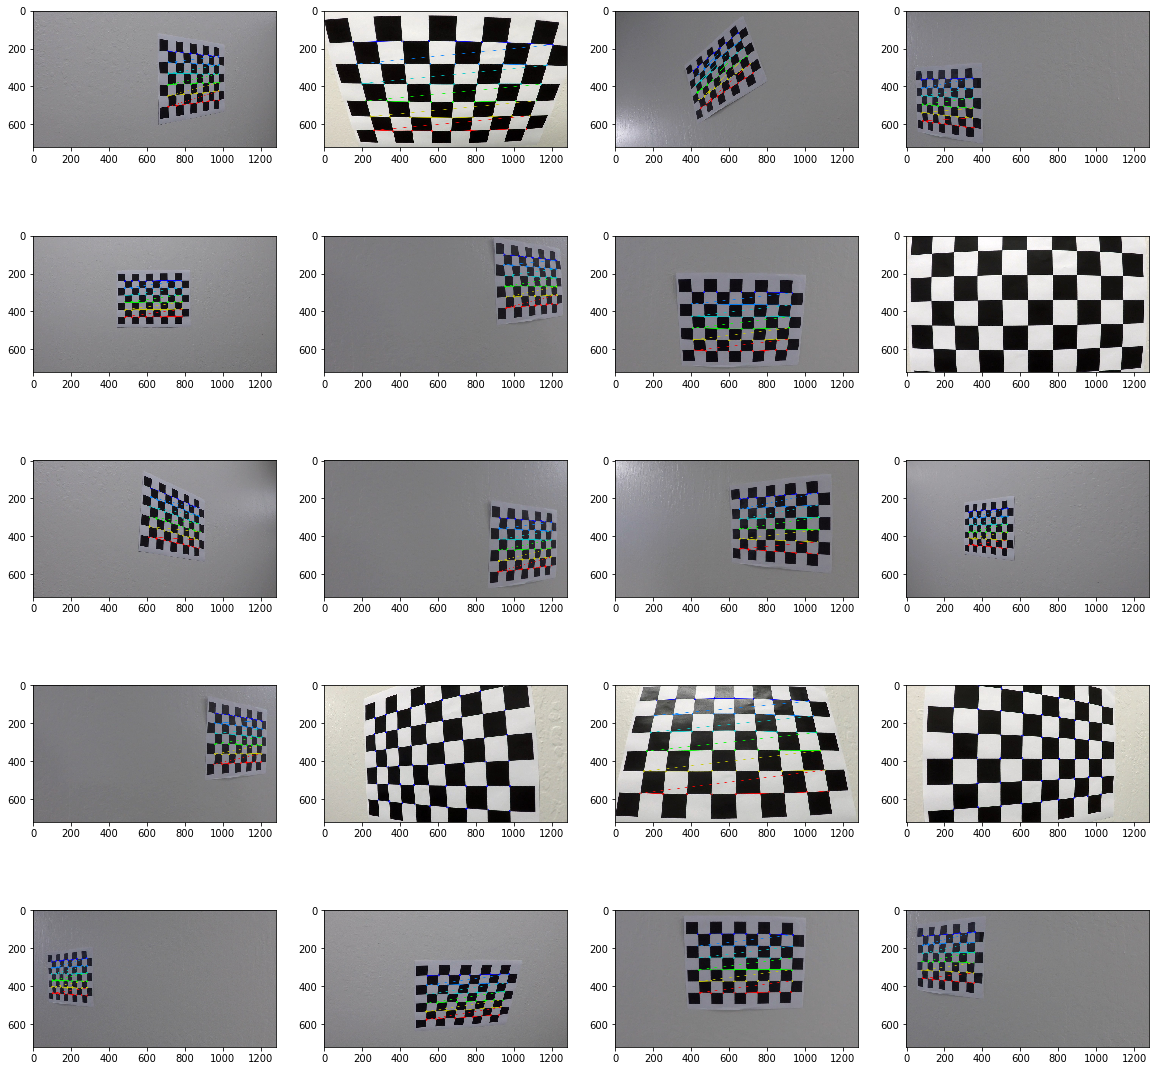

In [2]:
#calibrating camera
calib_images = glob.glob('camera_cal/*.jpg')
dir_l = len(os.listdir('camera_cal'))
obj_p = np.zeros((9 * 6, 3), np.float32) 
obj_p[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

obj_points=[]
img_points=[]

fig,ax = plt.subplots(5,4,figsize=(20.,20.))
plts = ax.ravel()

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for idx, fname in enumerate(calib_images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        obj_points.append(obj_p)
        # refine image points:
        # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
        refined_corners = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        img_points.append(refined_corners)
        
    draw = cv2.drawChessboardCorners(img,(9,6),corners,ret)
    plts[idx].imshow(draw)

In [3]:
#generating the distortion matrix and required parameters to undistort
board_img = mpimg.imread(calib_images[14])
ret, mat, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points,(board_img.shape[1],board_img.shape[0]), None, None)

# correcting the distorted the image

In [4]:
#creating folder to save testing output_images
if os.path.isdir('output_images'):
    shutil.rmtree('output_images')
    os.mkdir('output_images')
else:
    os.mkdir('output_images')

In [5]:
def undistort(img,mat,dist):
    '''
    used for image undistortion
    we should give mat:camera matrix and dist:distortion coefficients
    '''
    undist = cv2.undistort(img, mat, dist, None, mat)
    return undist

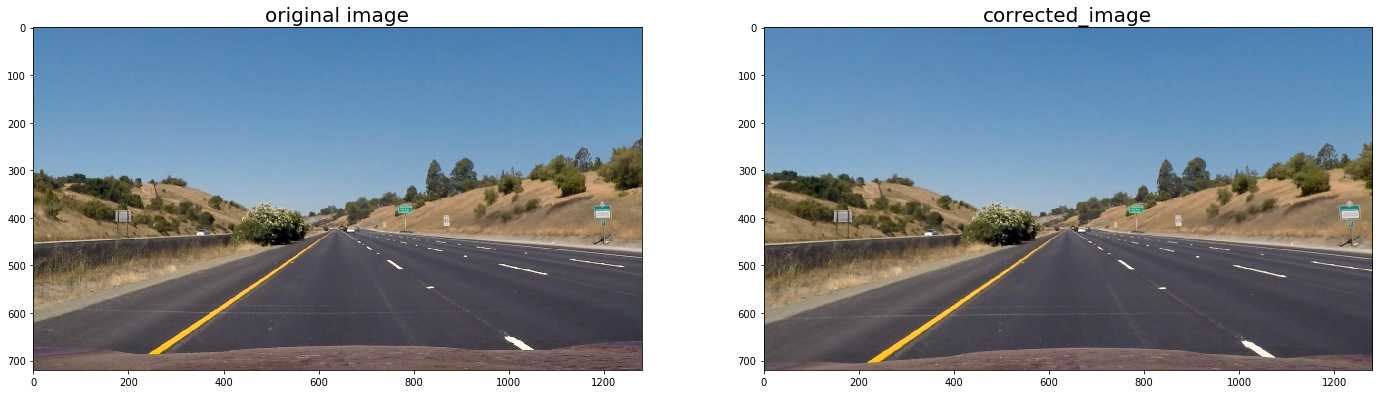

In [6]:
img = mpimg.imread('test_images/straight_lines1.jpg')
und_img = undistort(img,mat,dist)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(24,9))
ax1.imshow(img)
ax1.set_title('original image',fontsize=20)
ax2.imshow(und_img)
ax2.set_title('corrected_image',fontsize=20)
fig.savefig('output_images/original_vs_corrected.png')

# warping the image after selecting region of interest

In [7]:
def warp_img(img,src,dst):

    warp_matrix = cv2.getPerspectiveTransform(src, dst)
    unwarp_matrix = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, warp_matrix , (img.shape[1],img.shape[0]))
    return warped, warp_matrix, unwarp_matrix

def source(img_size):
    src = np.float32(
        [
            [(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]
        ])
    
    return src

def destination(img_size):
    dst = np.float32(
        [
            [(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]
        ])
    
    return dst

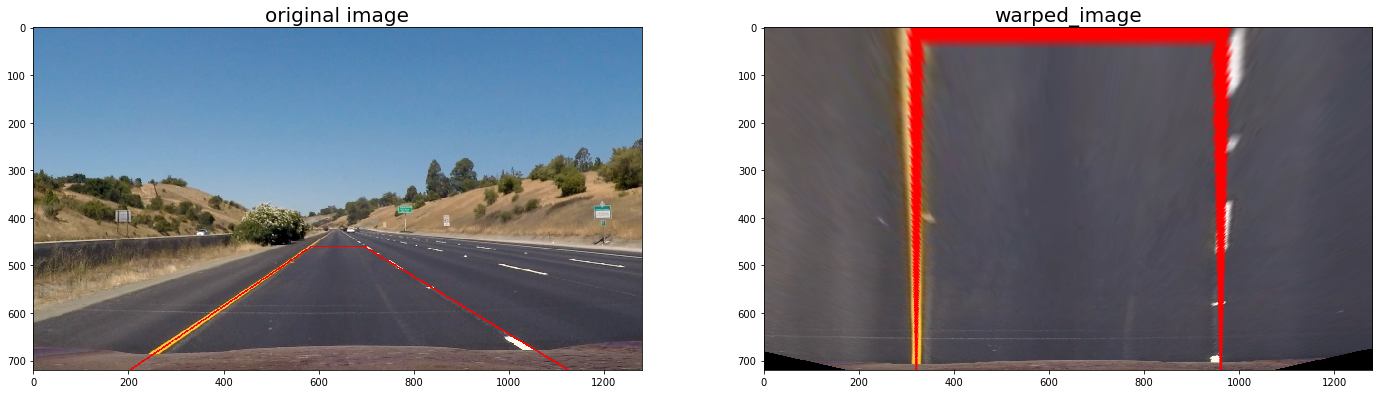

In [8]:
img_size = [img.shape[1],img.shape[0]]
copy = np.copy(img)
src_points = np.array(
    [
        [(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]
    ],np.int32)
copy=cv2.polylines(copy,[src_points],isClosed=True,color=(255,0,0),thickness=2)
src = source(img_size)
dst = destination(img_size)
warped_img, warp_matrix, unwarp_matrix = warp_img(copy,src,dst)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(24,9))
ax1.imshow(copy)
ax1.set_title('original image',fontsize=20)
ax2.imshow(warped_img)
ax2.set_title('warped_image',fontsize=20)
fig.savefig('output_images/warped_img.png')

# filtering the image

In [9]:
#detect the gradient changes to detect lines

def gradient_threshold(img, orient='x', sobel_kernel= 3,grad_thresh=(0,255)):
    '''
    apply sobel operator to detect the gradient changes in x or y directions
    '''
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel) 
    else:
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel) 
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel=np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel>grad_thresh[0]) & (scaled_sobel<=grad_thresh[1])]=1
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sbinary) # Remove this line
    return binary_output

def mag_threshold(img,sobel_kernel= 3, mag_thresh=(0,255)):
    '''
    apply sobel operator to detect the magnitude of gradient
    '''
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x and y 
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel) 
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel) 
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.sqrt(sobelx**2+sobely**2) 
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel>mag_thresh[0]) & (scaled_sobel<=mag_thresh[1])]=1
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sbinary) # Remove this line
    return binary_output


def dir_threshold(img,sobel_kernel= 3, dir_thresh=(0,np.pi/2)):
    '''
    apply sobel operator to detect the direction of gradient
    '''
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x and y and take their absolute value
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel) 
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 3) find the direction of gradient
    grad_sobel = np.arctan2(abs_sobely,abs_sobelx)
    # 4) Create a mask of 1's where the scaled gradient magnitude 
    sbinary = np.zeros_like(grad_sobel)
    sbinary[(grad_sobel>dir_thresh[0]) & (grad_sobel<=dir_thresh[1])]=1
            # is > thresh_min and < thresh_max
    # 5) Return this mask as your binary_output image
    binary_output = np.copy(sbinary) # Remove this line
    return binary_output

def threshold_image(undist):
    hls = cv2.cvtColor(undist,cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    hsv = cv2.cvtColor(undist,cv2.COLOR_RGB2HSV)
    h = hls[:,:,0]
    s = hls[:,:,1]
    v = hls[:,:,2]
    
    RGB = undist
    R = RGB[:,:,0]
    G = RGB[:,:,1]
    B = RGB[:,:,2]

    gradx = gradient_threshold(undist, orient='x', sobel_kernel=3, grad_thresh=(30, 255))
    grady = gradient_threshold(undist, orient='y', sobel_kernel=3, grad_thresh=(20, 100))
    mag_binary = mag_threshold(undist, sobel_kernel=9, mag_thresh=(50, 250))
    dir_binary = dir_threshold(undist, sobel_kernel=15, dir_thresh=(0.7, 1.1))

    binary = np.zeros_like(dir_binary)
    binary[(R>200)&(R<=255)]=1
    combined = np.zeros_like(binary)
    combined[((gradx == 1)&(grady == 1)|(mag_binary==1)&(dir_binary==1))|(binary==1)] = 1
    
    return combined

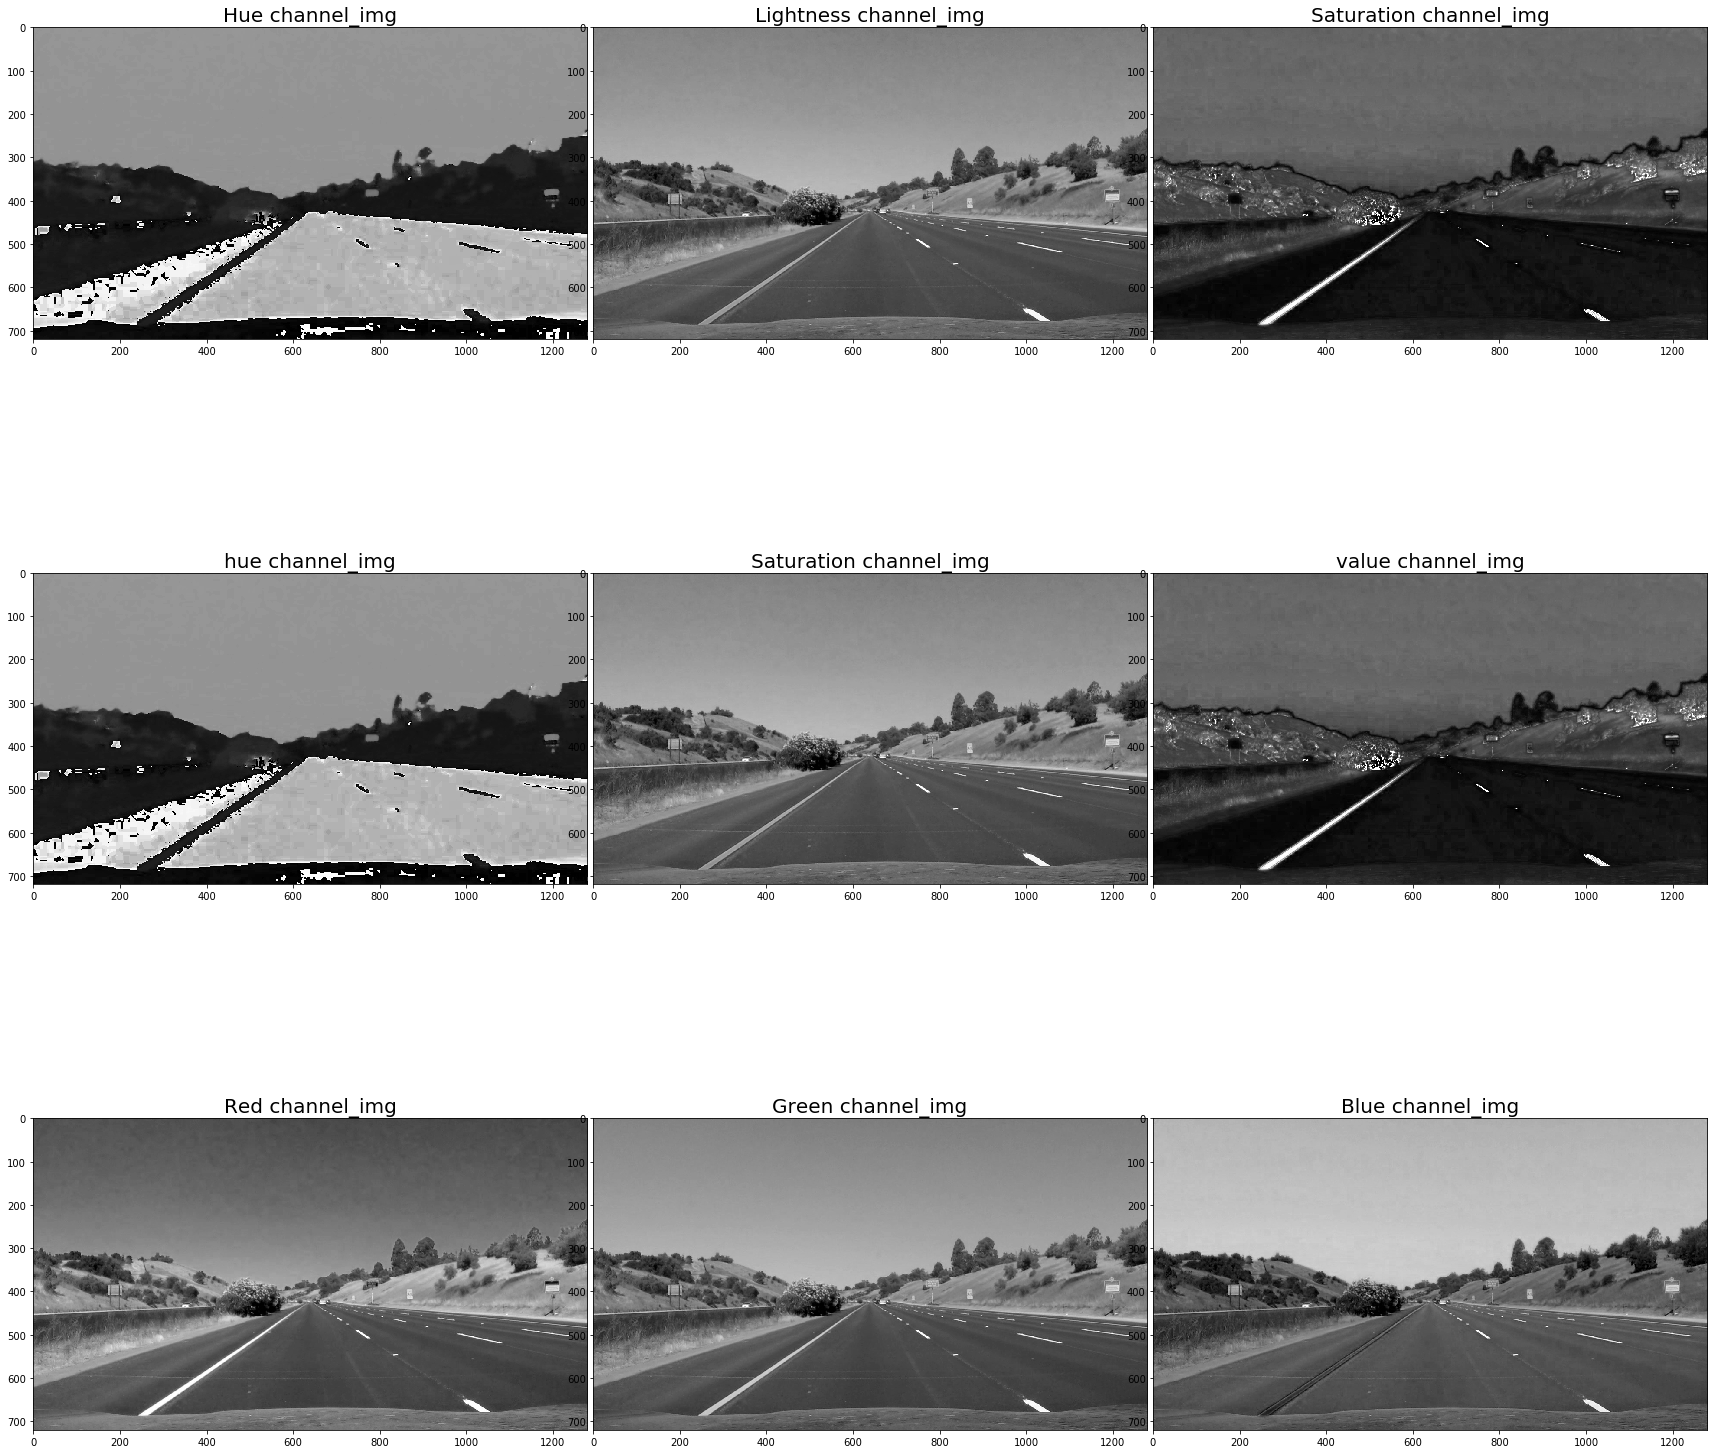

In [10]:
hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
h = hls[:,:,0]
s = hls[:,:,1]
v = hls[:,:,2]
    
RGB = img
R = RGB[:,:,0]
G = RGB[:,:,1]
B = RGB[:,:,2]

fig,ax=plt.subplots(3,3,figsize=(30,30))
fig.subplots_adjust(hspace = .01, wspace=.01)
axs = ax.ravel()
axs[0].imshow(H,cmap='gray')
axs[0].set_title('Hue channel_img',fontsize=20)
axs[1].imshow(L,cmap='gray')
axs[1].set_title('Lightness channel_img',fontsize=20)
axs[2].imshow(S,cmap='gray')
axs[2].set_title('Saturation channel_img',fontsize=20)
axs[3].imshow(h,cmap='gray')
axs[3].set_title('hue channel_img',fontsize=20)
axs[4].imshow(s,cmap='gray')
axs[4].set_title('Saturation channel_img',fontsize=20)
axs[5].imshow(v,cmap='gray')
axs[5].set_title('value channel_img',fontsize=20)
axs[6].imshow(R,cmap='gray')
axs[6].set_title('Red channel_img',fontsize=20)
axs[7].imshow(G,cmap='gray')
axs[7].set_title('Green channel_img',fontsize=20)
axs[8].imshow(B,cmap='gray')
axs[8].set_title('Blue channel_img',fontsize=20)
fig.savefig('output_images/color_channels.png')

I found red channel is showing lanes clearly after oberving many images

After trail and error I have choosen threshold values for x grad,y grad, magnitude gradient and direction gradient
The following binary image shows after combining all the filtered images 

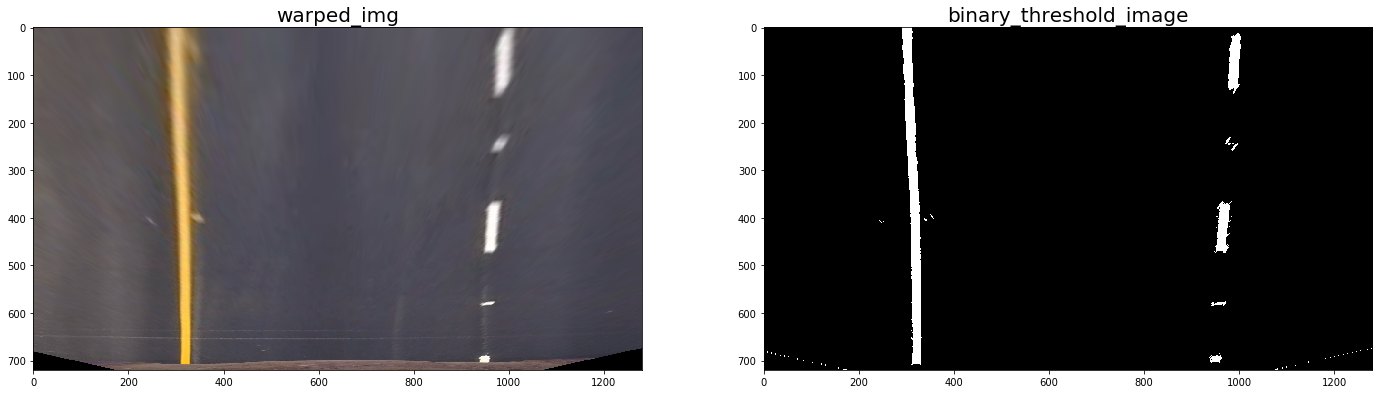

In [11]:
img_size = [img.shape[1],img.shape[0]]
src = source(img_size)
dst = destination(img_size)
warped_img, warp_matrix, unwarp_matrix = warp_img(img,src,dst)
combined = threshold_image(warped_img)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(24,9))
ax1.imshow(warped_img)
ax1.set_title('warped_img',fontsize=20)
ax2.imshow(combined,cmap='gray')
ax2.set_title('binary_threshold_image',fontsize=20)
fig.savefig('output_images/warped_to_binarythreshold.png')

# function for histogram

In [12]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half,axis=0)
    
    return histogram

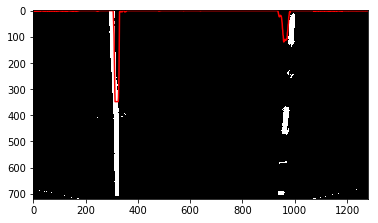

In [13]:
histogram = hist(combined)
plt.imshow(combined,cmap='gray')
plt.plot(histogram,'r')
plt.savefig('output_images/histogram.png')

# detecting the lane lines using the sliding window

In [14]:

def find_lane_pixels(binary_warped):
    '''
    this function takes in the binary image and detects the lane lines
    and fits a polynomial
    '''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    binary_warped = binary_warped.astype(np.uint8)*255
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&
        (nonzerox>=win_xleft_low)&(nonzerox<win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&
        (nonzerox>=win_xright_low)&(nonzerox<win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        # Remove this when you add your function
        if (len(good_left_inds)>minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if (len(good_right_inds)>minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return left_fit,right_fit,out_img

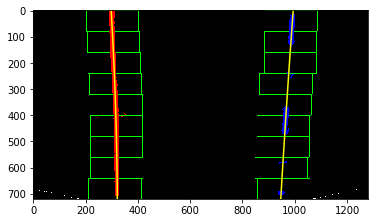

In [15]:
left_fit,right_fit,out_img=fit_polynomial(combined)
plt.imshow(out_img)
plt.imsave('output_images/window_image.png',out_img)

In [16]:
def fit_poly(img, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img[0]-1, img[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(warped,left_fit,right_fit,unwarp_matrix):
    
    binary_warped = warped.astype(np.uint8)*255
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result


#### using the previous polynomial coefficients we will detect lane lines and fit a polynomial

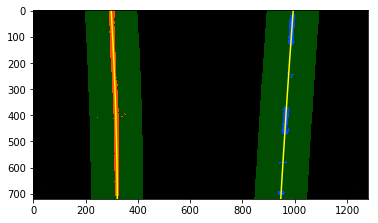

In [17]:
result = search_around_poly(combined,left_fit,right_fit,unwarp_matrix)
plt.imshow(result)
plt.imsave('output_images/previous_fit_img.png',result)

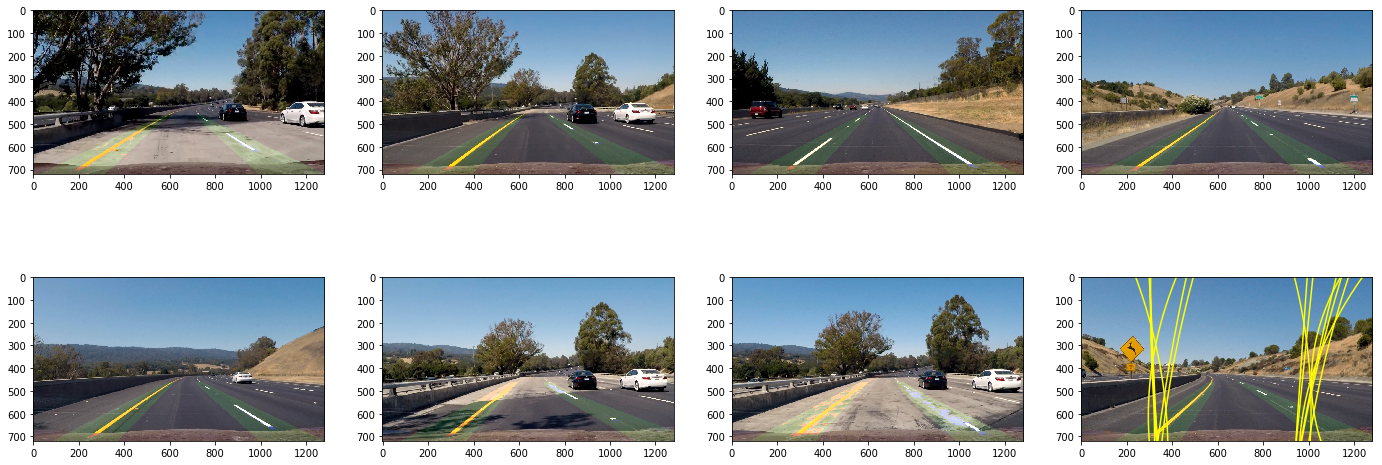

In [18]:
test_img = glob.glob('test_images/*.jpg')
len_dr = len(os.listdir('test_images'))
fig,ax = plt.subplots(len_dr//4,len_dr//2,figsize=(24,9))
axs = ax.ravel()
for idx,fname in enumerate(test_img):
    img = plt.imread(fname)
    copy = np.copy(img)
    undist = undistort(copy,mat,dist) # undistort the image

    img_size = (img.shape[1], img.shape[0])
    src = source(img_size)
    dst = destination(img_size)

    warped, warp_matrix, unwarp_matrix = warp_img(undist,src,dst)
    
    combined = threshold_image(warped) #bit image

    #left_fit,right_fit,out_img = fit_polynomial(combined) 
    result = search_around_poly(combined,left_fit,right_fit,unwarp_matrix)
    unwarped = cv2.warpPerspective(result, unwarp_matrix, (warped.shape[1], warped.shape[0]))
    final = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    axs[idx].imshow(final)
    mpimg.imsave('output_images/output_of_'+str(idx)+'.png',final)

## detect the polynomial coefficients by using sliding window search

In [19]:
def window_search(warped):
    '''
    obtain the left and right coefficients
    '''
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
        
    return left_fit,right_fit

### using the previous the previous line coefficients search for the lane pixels and fit a polynomial.

In [20]:
def search_using_prevfit(warped,left_fit,right_fit):
    
    binary_warped = warped.astype(np.uint8)*255
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if (len(leftx)!=0):
        left_fit = np.polyfit(lefty, leftx, 2)
    if (len(rightx)!=0):
        right_fit = np.polyfit(righty, rightx, 2)
        
    return left_fit,right_fit

# measuring the radius of curvature in real world measurment

In [21]:
def measure_curvature_real(left_fitx,right_fitx,ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad =((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad,left_fit_cr,right_fit_cr

# drawing path

In [22]:
def path_fill(warped,undist,unwarp_matrix,left_fit,right_fit):
    
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_curverad, right_curverad,left_fit_cr,right_fit_cr = measure_curvature_real(left_fitx,right_fitx,ploty)

    #if (abs(left_curverad-right_curverad)<=500)|(abs(left_curverad-right_curverad)>=2000|(left_curverad>2500)|(right_curverad>2500)):
        #left_fit,right_fit = window_search(warped)
        #left_curverad, right_curverad = measure_curvature_real(left_fitx,right_fitx,ploty)
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    #offset 
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    X = img.shape[1]*xm_per_pix
    Y = img.shape[0]*ym_per_pix
    Drive_Center = X / 2
    Left_point = left_fit_cr[0]*Y**2 + left_fit_cr[1]*Y + left_fit_cr[2]
    Right_point = right_fit_cr[0]*Y**2 + right_fit_cr[1]*Y + right_fit_cr[2]
    MidPoint = Left_point + (Right_point - Left_point)/2
    Offset = MidPoint - Drive_Center

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    unwarped = cv2.warpPerspective(color_warp, unwarp_matrix, (undist.shape[1], undist.shape[0]))
    #unwarp_final = cv2.warpPerspective(test_final, unwarp_matrix, (undist.shape[1], undist.shape[0]))
    result = cv2.addWeighted(undist,1,unwarped,0.3,0)
    
    #radius measurments
    curvature_string = "Left Radius of curvature:  %.2f m" % left_curverad
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)
    
    curvature_string = "Right Radius of curvature: %.2f m" % right_curverad
    cv2.putText(result,curvature_string , (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)
    
    curvature_string = "offset: %.2f m" % Offset
    cv2.putText(result,curvature_string , (100, 210), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)    
    
    return left_fit,right_fit,result
    

In [23]:
def processor(img):
    
    global left_fit
    global right_fit
    
    #undsitorting and warping the image
    undist = undistort(img,mat,dist)    
    img_size = (img.shape[1], img.shape[0])
    src = source(img_size)
    dst = destination(img_size)
    warped, warp_matrix, unwarp_matrix = warp_img(undist,src,dst)
    combined = threshold_image(warped)
    
    # use the window method to search for lanes for fitting line coefficients
    if (left_fit is None) and (right_fit is None):
        left_fit,right_fit = window_search(combined)
    else:
        left_fit,right_fit = search_using_prevfit(combined,left_fit,right_fit)
    
    left_fit,right_fit,result = path_fill(combined,undist,unwarp_matrix,left_fit,right_fit)
    

    return result
    

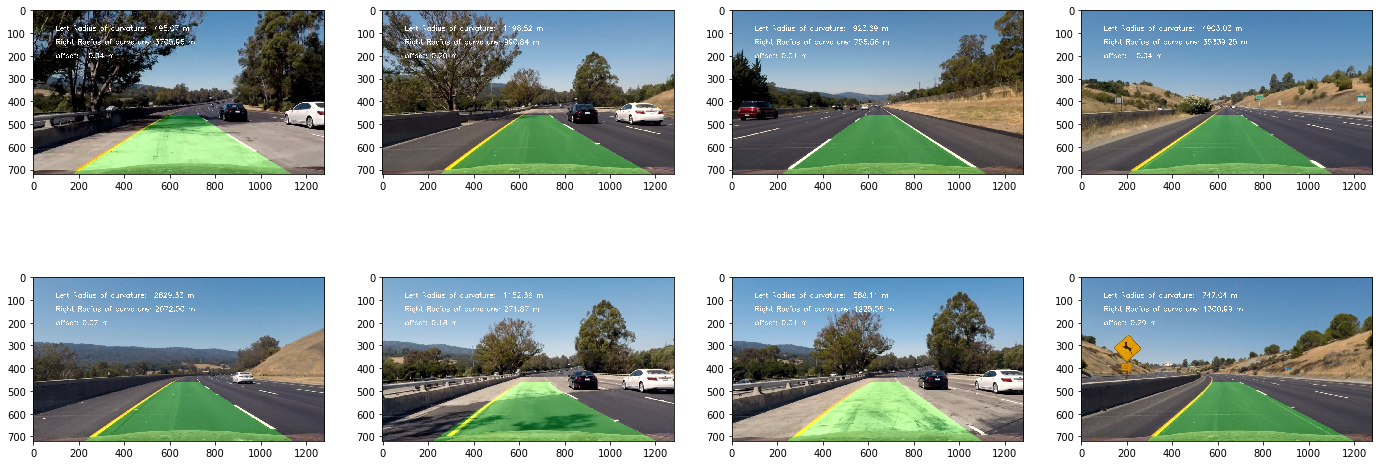

In [24]:
test_img = glob.glob('test_images/*.jpg')
len_dr = len(os.listdir('test_images'))
fig,ax = plt.subplots(len_dr//4,len_dr//2,figsize=(24,9))
axs = ax.ravel()
for idx,fname in enumerate(test_img):
    t_img = mpimg.imread(fname)
    result = processor(t_img)
    axs[idx].imshow(result)
    mpimg.imsave('output_images/final_output_of_'+str(idx)+'.png',final)

In [25]:
left_fit = None
right_fit = None

clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(processor) #NOTE: this function expects color images!!
video_output = 'project_video_output.mp4'
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:49<00:00,  3.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 41s, sys: 3.26 s, total: 4min 44s
Wall time: 6min 52s


In [26]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</videot
""".format(video_output))